# Preparing Tokyo weather station data

In [193]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5

import warnings
warnings.filterwarnings('ignore')

In [194]:
#read dataset
df = pd.read_csv("../data/GSOD/merged_cities/TOKYO.csv")

In [195]:
df

,Unnamed: 0,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,TEMP,TEMP_ATTRIBUTES,DEWP,...,MXSPD,GUST,MAX,MAX_ATTRIBUTES,MIN,MIN_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,SNDP,FRSHTT
0,0,47662099999,1990-01-01,35.683333,139.766667,36.0,"TOKYO, JA",41.1,8,17.1,...,5.1,999.9,49.6,,34.5,,0.00,I,999.9,0
1,1,47662099999,1990-01-02,35.683333,139.766667,36.0,"TOKYO, JA",42.4,8,23.2,...,9.9,999.9,48.9,,33.3,,0.00,I,999.9,0
2,2,47662099999,1990-01-03,35.683333,139.766667,36.0,"TOKYO, JA",42.5,8,21.1,...,9.9,999.9,48.4,,36.3,,0.00,I,999.9,0
3,3,47662099999,1990-01-04,35.683333,139.766667,36.0,"TOKYO, JA",42.0,8,14.7,...,15.0,999.9,48.7,,36.1,*,0.00,I,999.9,0
4,4,47662099999,1990-01-05,35.683333,139.766667,36.0,"TOKYO, JA",43.7,8,22.1,...,8.9,999.9,51.1,,34.2,*,0.00,I,999.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10510,10510,47662099999,2019-11-14,35.683333,139.766667,36.0,"TOKYO, JA",59.1,24,40.9,...,11.1,999.9,72.1,,50.4,*,0.02,G,999.9,0
10511,10511,47662099999,2019-11-15,35.683333,139.766667,36.0,"TOKYO, JA",53.7,23,44.2,...,7.0,999.9,62.8,,46.2,*,0.00,G,999.9,0
10512,10512,47662099999,2019-11-16,35.683333,139.766667,36.0,"TOKYO, JA",55.8,24,42.0,...,6.0,999.9,66.0,,46.0,,0.00,G,999.9,0
10513,10513,47662099999,2019-11-17,35.683333,139.766667,36.0,"TOKYO, JA",56.6,24,37.6,...,11.1,999.9,67.5,,46.8,,0.00,G,999.9,0


In [196]:
# drop old index column
df.drop(["Unnamed: 0"], axis=1, inplace=True)

# drop redundant column swith info about weather station
df.drop(["STATION", "LATITUDE", "LONGITUDE", "ELEVATION", "NAME"], axis=1, inplace=True)

# drop "attributes"
df.drop(["TEMP_ATTRIBUTES", "DEWP_ATTRIBUTES", "SLP_ATTRIBUTES", "STP_ATTRIBUTES", 
         "VISIB_ATTRIBUTES", "WDSP_ATTRIBUTES", "MAX_ATTRIBUTES", "MIN_ATTRIBUTES", "PRCP_ATTRIBUTES"], 
        axis=1, inplace=True)

# drop redundant weather info (max speed of wind, maximum wind gust, min and max temperature, snow depth,  
# indicator for occurrence of: fog, rain or drizzle, snow or ice pellets, hail, thunder, 
# tornado/funnel cloud respectively )
df.drop(["MXSPD", "GUST", "MAX", "MIN", "SNDP", "FRSHTT"], axis=1, inplace=True)

In [197]:
# change index
df.set_index([pd.to_datetime(df.DATE)], inplace=True)
df.drop(["DATE"], axis=1, inplace=True)

In [198]:
df.head()

,TEMP,DEWP,SLP,STP,VISIB,WDSP,PRCP
DATE,,,,,,,
1990-01-01,41.1,17.1,1015.8,999.9,21.7,4.0,0.0
1990-01-02,42.4,23.2,1015.1,999.9,13.2,5.8,0.0
1990-01-03,42.5,21.1,1010.9,999.9,19.4,7.5,0.0
1990-01-04,42.0,14.7,1017.1,999.9,25.6,10.5,0.0
1990-01-05,43.7,22.1,1019.3,999.9,15.5,5.9,0.0


__Missing data handling__

In [199]:
df.isna().sum()

TEMP     0
DEWP     0
SLP      0
STP      0
VISIB    0
WDSP     0
PRCP     0
dtype: int64

As we can see, there are no nans in the data

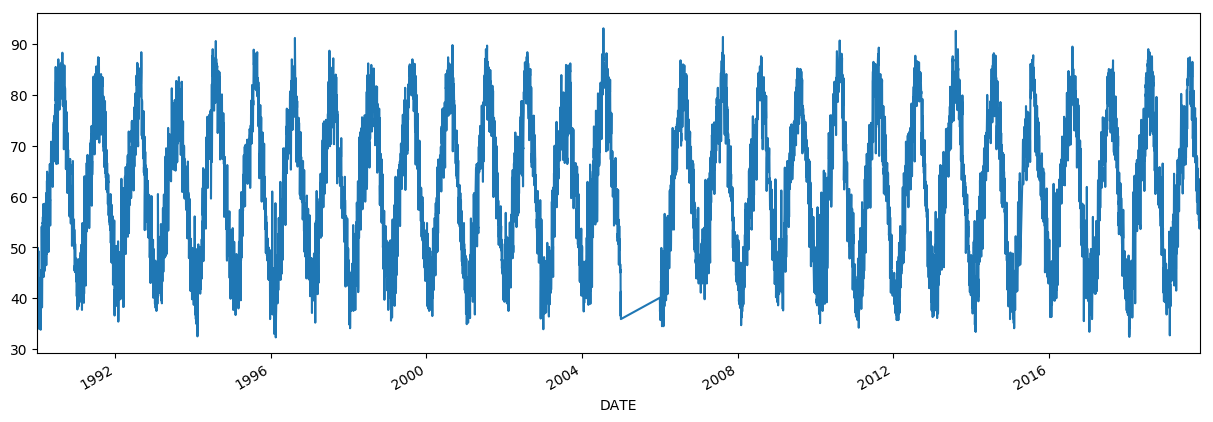

In [200]:
df.TEMP.plot()

There are no weather data for 2005 year, so lets impute it

In [201]:
# returns mean value for exact day of a year
def column_mean(df, column, date):
    total = 0
    all_years = [day for day in df.index if (str(date)[4:] in str(day) and str(date)[:4] not in str(day))]
    
    for year in all_years:
        total += df.at[year, column]
    
    return (total / len(all_years))

In [202]:
# creates data for whole year, using mean value imputation
def create_missing_year(df, year):
    dates = pd.date_range(start='1/1/' + str(year), end='1/1/' + str(year + 1))[:-1]
    missing_data = dict()
    
    for col in df.columns:
        missing_data[col] = []
        
    for col in df.columns:
        for date in dates:
            missing_data[col].append(column_mean(df, col, date))
    
    missing_data = pd.DataFrame(data=missing_data, index=dates)
    
    return missing_data

In [203]:
# inserts missing year to dataset
def insert_year(df, year_df,  year):
    all_years = [str(date)[:4] for date in df.index if "-01-01" in str(date)]
    previous_year = str(year)
    while not previous_year in all_years:
        previous_year = str(int(previous_year) - 1)
    
    last_day = [date for date in df.index if previous_year in str(date)][-1]
    
    first_part = df.loc[:last_day, :]
    second_part = df.loc[last_day:,:][1:]
    
    return pd.concat([first_part, year_df, second_part])

In [204]:
missing_year =  create_missing_year(df, 2005)

In [206]:
df = insert_year(df, missing_year, 2005)

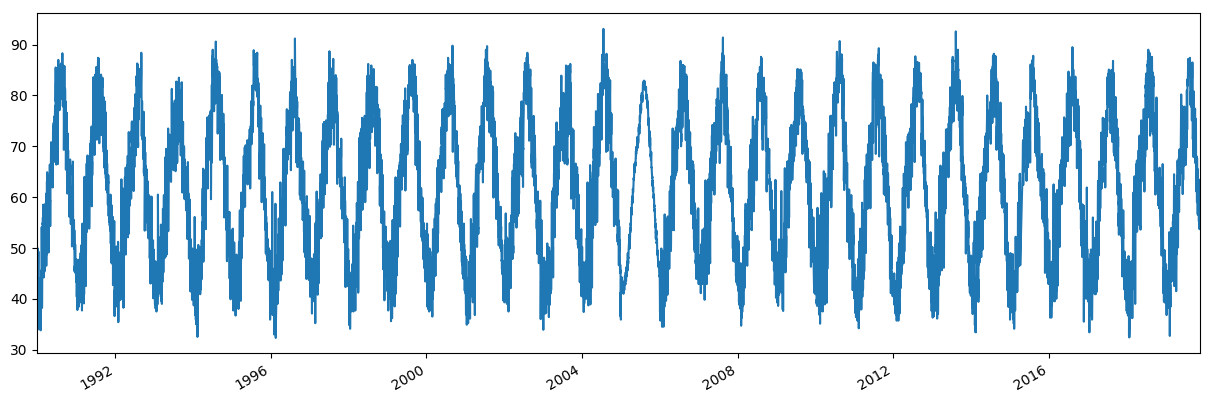

In [207]:
df.TEMP.plot()

In [164]:
df.head()

,TEMP,DEWP,SLP,STP,VISIB,WDSP,PRCP
1990-01-01,41.1,17.1,1015.8,999.9,21.7,4.0,0.0
1990-01-02,42.4,23.2,1015.1,999.9,13.2,5.8,0.0
1990-01-03,42.5,21.1,1010.9,999.9,19.4,7.5,0.0
1990-01-04,42.0,14.7,1017.1,999.9,25.6,10.5,0.0
1990-01-05,43.7,22.1,1019.3,999.9,15.5,5.9,0.0


__Data reduction__

As we have daily data for 30 years (more that 10,000 instances), it will take a lot of time to fit good model for such big data. Here I reduce daily data to weekly, by taking mean of whole week as value of that one week 

In [208]:
# returns dict with mean values of corresponding column at the certain week 
def week_mean(df, date):
    week = dict()
    
    digits = list(date)
    digits[-2:] = str(int("".join(digits[-2:])) + 6)
    end = "".join(digits)
    
    data = df.loc[date:end, :]
    
    for col in data.columns:
        week[col] = data[col].mean()
    
    return week

In [209]:
# generates month data
def create_month_data(df, year_n_month):
    month = dict()
    for col in df.columns:
        month[col] = []
    
    checkpoints = ["-01", "-08", "-15", "-22"]
    indexes = [year_n_month + day for day in checkpoints]
    
    for idx in indexes:
        week = week_mean(df, idx)
        for i in month.keys():
            month[i].append(week[i])
            
    new_month = pd.DataFrame(data=month, index=indexes)
    
    return new_month

In [210]:
def reduce_dataset(df):
    months = [str(year_n_month)[:7] for year_n_month in df.index if str(year_n_month)[8:10] == "01"]

    new_months = [create_month_data(df, month) for month in months]
    
    df = pd.concat(new_months)
    
    return df

In [211]:
df =  reduce_dataset(df)

In [212]:
df

,TEMP,DEWP,SLP,STP,VISIB,WDSP,PRCP
1990-01-01,43.300000,19.657143,1016.614286,999.900000,18.200000,7.571429,0.000000
1990-01-08,44.028571,26.328571,1018.385714,999.900000,7.828571,6.457143,0.022857
1990-01-15,39.128571,26.485714,1018.385714,999.900000,6.300000,6.057143,14.405714
1990-01-22,38.071429,15.614286,1021.585714,999.900000,13.857143,7.000000,0.000000
1990-02-01,39.328571,30.285714,1026.857143,999.900000,4.142857,6.342857,0.202857
...,...,...,...,...,...,...,...
2019-10-22,63.100000,57.171429,1015.171429,12.314286,12.671429,5.328571,1.098571
2019-11-01,59.800000,47.314286,1015.171429,12.285714,14.000000,4.357143,0.064286
2019-11-08,57.628571,44.571429,1014.128571,11.228571,14.042857,4.885714,0.040000
2019-11-15,57.375000,44.825000,1016.825000,13.925000,14.850000,5.625000,0.000000


In [214]:
df[df.TEMP.isnull()].index.tolist()

['2015-04-08', '2015-04-15', '2015-04-22', '2019-11-22']

As we can see, during data reduction new missing values appear, so here I impute them

In [215]:
for indx in df[df.TEMP.isnull()].index.tolist():
    for col in df.columns:
        df.xs(indx)[col] = column_mean(test, col, indx)

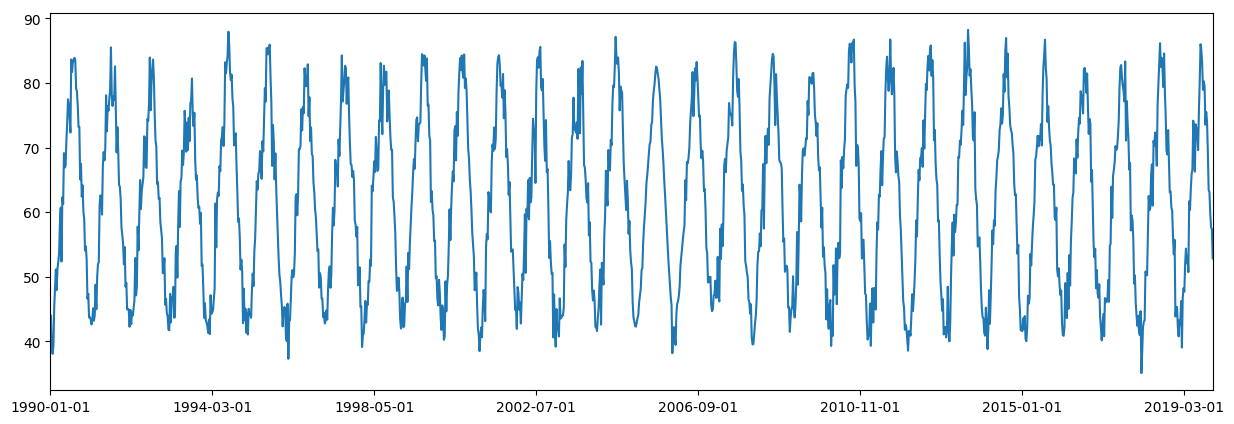

In [216]:
df.TEMP.plot()

Now, our data is cleaned, reduced in more than 7 times and without missing values

In [217]:
df.describe()

,TEMP,DEWP,SLP,STP,VISIB,WDSP,PRCP
count,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000
mean,61.794197,47.654190,1013.797376,136.776095,10.038977,6.112531,3.102225
std,13.669244,17.359724,4.569929,247.812902,8.994451,1.081061,6.653214
min,35.085714,12.100000,1001.171429,1.428571,2.485714,3.257143,0.000000
25%,48.750000,31.867857,1010.464286,10.467857,6.953571,5.353571,0.037143
50%,62.364286,48.785714,1013.871429,14.900000,9.207143,6.028571,0.167143
75%,73.307143,63.771429,1017.260714,151.132143,11.775000,6.800000,0.567500
max,88.200000,77.442857,1028.942857,999.900000,153.971429,10.271429,42.994286


__Outliers__

In [185]:
def replace_outliers(df, column):
    m = df[column].mean()
    std = df[column].std()
    
    for index, row in df.iterrows():
        if (abs(row[column]) > m + 3 * std):
            df.xs(index)[column] = column_mean(df, column, index)
    return df

In columns VISIB and PRCP there are some outliers, so lets replace them with mean value.

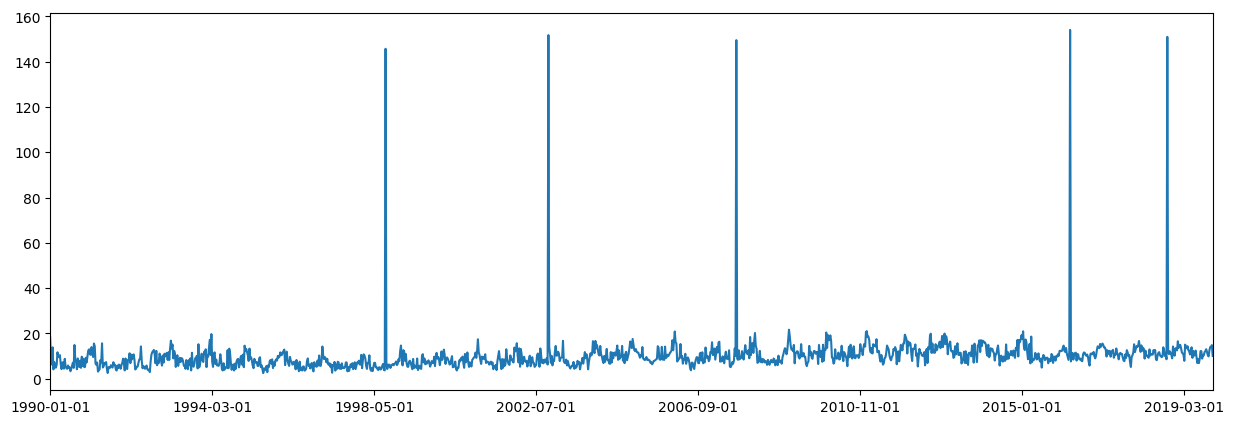

In [181]:
df.VISIB.plot()

In [188]:
df = replace_outliers(df, "VISIB")

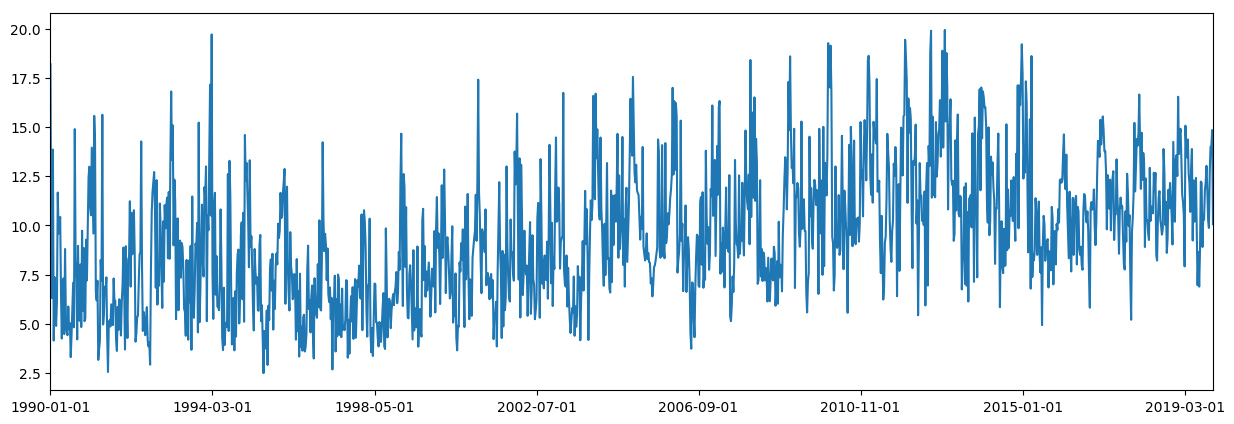

In [189]:
df.VISIB.plot()

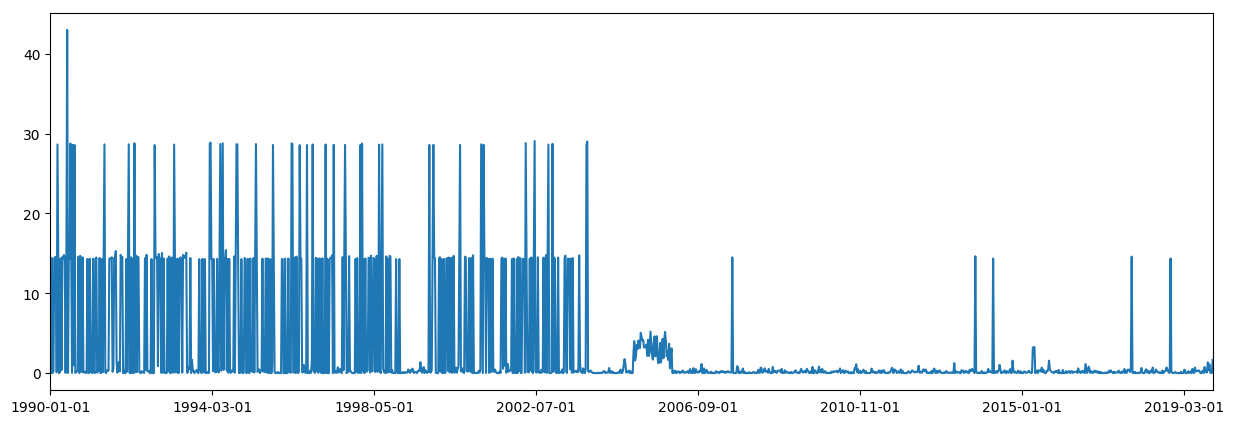

In [218]:
df.PRCP.plot()

In [219]:
df = replace_outliers(df, "PRCP")

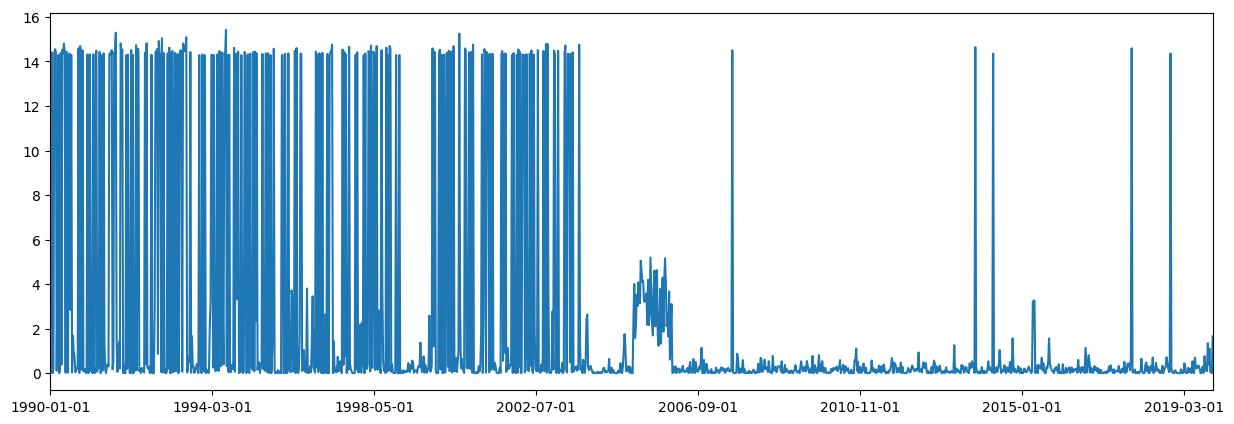

In [220]:
df.PRCP.plot()

In [192]:
df.to_csv("../analysis/Tokyo.csv")